<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/RadiopharmaceuticalNetworkALNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Packages**

In [2]:
!pip install geopandas contextily shapely pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.1 MB/s eta 0:00:00


In [26]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import itertools

import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import pandas as pd
import numpy as np

import heapq

# **Initial Parameters**

In [4]:
hospitals = {
    "Michigan Diagnostics Center": (42.48853947067958, -83.10526194019599),
    "Nuclear Medicine PET Scan at University Hospital": (42.373423665779875, -83.74705677218591),
    "Regional Medical Imaging Southgate": (42.25969201846909, -83.17027457939628),
    "Beaumont PET/CT St. Clair Shores": (42.56791387603854, -82.8846300648719),
    "Regional Medical Imaging Novi": (42.49902362908627, -83.42865686601002),
    "Henry Ford Radiology and Imaging - Macomb Hospital": (42.64671830391097, -82.96015224192095),
    "Computed Tomography (CT/CAT scan) at Livonia Center for Specialty Care": (42.452871313282124, -83.43988814124502),
    "Computed Tomography (CAT/CT scan) at East Ann Arbor Health and Geriatrics Center": (42.34030658958308, -83.677349389071),
    "Synergy MRI: Royal Oak - Pure Open MRI": (42.50612096423798, -83.14466604935329),
    "Michigan Resonance Imaging": (42.6915481520167, -83.23932965490553),
    "Computed Tomography (CAT/CT scan) at Canton Health Center": (42.35216501570914, -83.48962664585721),
    "Therma-Scan of Michigan, LLC": (42.53450224783935, -83.28906815951773),
    "Life Scan Imaging Corporation": (42.55223400342188, -83.01309968231458),
    "Scan Clear MRI": (42.639636951333856, -82.96175670981167),
    "McLaren Clarkston - Diagnostic Imaging": (42.749307331742, -83.38212729717925),
    "Corewell Health William Beaumont University Hospital Imaging Center - 3581 W 13 Mile Rd": (42.53686677288904, -83.19761348974691),
    "Corewell Health Farmington Hills Hospital Cancer PET - 27900 Grand River Ave": (42.46115756857247, -83.32917985678563),
    "Michigan Diagnostics": (42.56405237592633, -83.18156881083976),
    "University of Michigan Department of Radiology": (42.31065073827846, -83.7367147010275),
    "Magnetic Resonance Imaging (MRI) at University Hospital": (42.31302372082438, -83.74313257259035),
    "University of Michigan Radiology Department": (42.3308182381527, -83.66451364594526),
    "Henry Ford Radiology and Imaging - Henry Ford Hospital": (42.39483682739532, -83.09332307685038),
    "Cat Scan Center-Clarkston": (42.75048553064453, -83.42223899444716),
    "Karmanos Cancer Institute": (42.37587515709506, -83.0548158474732),
    "Corewell Health William Beaumont University Hospital Imaging Center (North) - 3601 West 13 Mile Rd": (42.54750602768598, -83.18798668240262),
    "University of Michigan Hospital": (42.3082776662676, -83.73029682946462),
    "West Ann Arbor Health Center": (42.30617469480637, -83.81869373445174),
    "Corewell Health Farmington Hills Hospital": (42.492773027416945, -83.32430899777493),
    "U of M nuclear medicine": (42.30567431128067, -83.73610211287075),
    "Xoran Technologies, LLC.": (42.2347479291253, -83.74979481977397),
    "H C S Group": (42.38891163244826, -83.47602561421753),
    "Brighton Center for Specialty Care": (42.5569552581989, -83.78832668728445),
    "Barbara Ann Karmanos Cancer Institute - Lawrence and Idell Weisberg Cancer Treatment Center": (42.53715336348327, -83.34675344872672),
    "Henry Ford Cancer - Detroit": (42.38923356016813, -83.08820419968758),
    "Bionicc Body Screening": (42.50779307035835, -83.26398543939487),
    "Medical Scan Inc": (42.60591583149083, -83.15000229177215),
    "Henry Ford Medical Center - Sterling Heights": (42.57052850357885, -83.07172470846498),
    "Corewell Health Dearborn Hospital": (42.31616234192726, -83.20218734731026),
    "University of Michigan Medical Center": (42.30302607557066, -83.73009342374314),
    "Henry Ford Hospital": (42.39578802444869, -83.07850907813186),
    "Children's Hospital of Michigan": (42.37245750030311, -83.0524165503628),
    "DMC Detroit Receiving Hospital": (42.371442933019594, -83.0524165503628),
    "McLaren Clarkston": (42.75377544900855, -83.36983337813187),
    "Huron Gastro Ann Arbor": (42.28356418243363, -83.6595742965488),
}

depot = {
    "EHMET health": (42.42980168639475, -83.52695942935674)
}

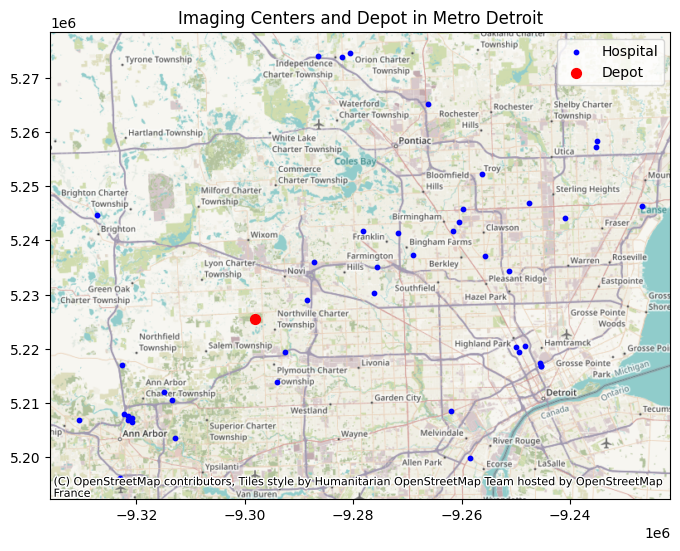

In [5]:
# 1. Build GeoDataFrames
hospital_points = []
for name, (lat, lon) in hospitals.items():
    # Note: geometry expects (longitude, latitude)
    hospital_points.append([name, Point(lon, lat)])

hospitals_gdf = gpd.GeoDataFrame(
    hospital_points,
    columns=["Name", "geometry"],
    crs="EPSG:4326"
)

depot_points = []
for name, (lat, lon) in depot.items():
    depot_points.append([name, Point(lon, lat)])

depot_gdf = gpd.GeoDataFrame(
    depot_points,
    columns=["Name", "geometry"],
    crs="EPSG:4326"
)

# 2. Reproject to Web Mercator
hospitals_3857 = hospitals_gdf.to_crs(epsg=3857)
depot_3857 = depot_gdf.to_crs(epsg=3857)

# 3. Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot hospitals in blue
hospitals_3857.plot(
    ax=ax,
    color='blue',
    markersize=10,
    label='Hospital'
)

# Plot depot in red
depot_3857.plot(
    ax=ax,
    color='red',
    markersize=50,
    label='Depot'
)

# Add a basemap behind it
cx.add_basemap(ax, crs=hospitals_3857.crs)

ax.legend()
plt.title("Imaging Centers and Depot in Metro Detroit")
plt.show()

In [6]:
# Distance Matrix Generator
nodes = {**depot, **hospitals} # Ensures depot is node 0

# Create a list of node names
node_names = list(nodes.keys())

# Define the haversine function to calculate distances
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points on Earth."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c  # Earth's radius in km
    return km

# Initialize an empty DataFrame for the distance matrix
distances = pd.DataFrame(index=node_names, columns=node_names, dtype=float)
distance_matrix_np = distances.to_numpy()

# Compute pairwise distances using the haversine formula
for name1 in node_names:
    lat1, lon1 = nodes[name1]
    for name2 in node_names:
        lat2, lon2 = nodes[name2]
        distances.loc[name1, name2] = haversine(lon1, lat1, lon2, lat2)

# Calculates the travel times and cost matrices
vehicle_speed = 60 # km/hour

t = (distances / vehicle_speed) * 60  # travel times in minutes
c = distances * 0.093  # travel costs

t_matrix_np = t.to_numpy()
c_matrix_np = c.to_numpy()

In [7]:
V = range(45)  # nodes including depot, 0 is depot
V_star = range(1, 45)  # nodes excluding depot
K = range(6)
vehicle_speed = 60  # vehicle speed in km/h

In [8]:
# Time window parameters (converted into minutes)
# First element of array is for the depot
a = [0, 480, 0, 450, 420, 390, 0, 480, 480, 450, 0, 480, 540, 0, 510, 420, 420, 480, 480, 480, 0, 0, 390, 0, 0, 480, 0, 420, 0, 0, 540, 0, 420, 420, 420, 540, 0, 0, 0, 0, 0, 0, 0, 0, 480]
b = [1440, 1020, 1440, 1170, 960, 1320, 1440, 990, 990, 1080, 1440, 990, 1020, 1440, 1020, 1110, 1020, 720, 1020, 1020, 1440, 1440, 1350, 1440, 1440, 1020, 1440, 1140, 1440, 1440, 1020, 1440, 1140, 1020, 1140, 1080, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1020]
s = [0] + [30] * (len(a) - 1) # Assume 30 min service per customer

num_customers = len(a) - 1
d = [0] + list(np.random.randint(1, 16, size=num_customers))
p = [0] + list(np.random.randint(1, 16, size=num_customers))

num_vehicles = 6
Q = list(np.random.randint(47, 114, size=num_vehicles))

cost_factor = 2.5
fixed_costs = [round(q * cost_factor, 2) for q in Q]

In [9]:
import heapq
from collections import defaultdict
from heapq import heappush, heappop

import numpy as np
import heapq
import random
import itertools
from copy import deepcopy

# **Initial Solution Algorithm**

In [12]:
class Vehicle:
    def __init__(self, vehicle_id, capacity, speed, cost, depot):
        self.vehicle_id = vehicle_id
        self.capacity = capacity
        self.speed = speed
        self.cost = cost
        self.route = [] # (customer_id, delivered, picked_up, arrival_time)
        self.current_time = 0

        # Updated Capacity Tracking
        self.full_vials = int(self.capacity * 0.75) # Start with 50% full vials
        self.empty_vials = 0 # Initially no empty vials
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials) # Available space
        self.current_location = depot

    def can_add_customer(self, node, travel_time):
        """
        Check if the vehicle can arrive within the time window.
        Returns (boolean) feasibility flag and expected arrival time.
        """
        # check if the vehicle has capacity
        if self.empty_vials == self.capacity:
            return False, self.current_time

        arrival_time = self.current_time + travel_time
        if arrival_time > b[node]:  # Too late
            return False, arrival_time
        if arrival_time < a[node]:  # Arrive early, wait
            arrival_time = a[node]
        return True, arrival_time

    def add_customer(self, node, delivery_demand, pickup_demand, travel_time):
        """
        Assigns a customer to the vehicle while ensuring delivery before pickup
        and allowing split deliveries.
        """
        # Step 1: Check feasibility (time window constraints)
        feasible, arrival_time = self.can_add_customer(node, travel_time)
        if not feasible:
            return False, delivery_demand, pickup_demand

        # Step 2: Deliver first, and update the vehicle load values
        delivered = min(self.full_vials, delivery_demand)
        self.full_vials -= delivered
        delivery_demand -= delivered
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        # Step 3: Pick up second, and update the vehicle load values
        picked_up = min(self.empty_space, pickup_demand)
        self.empty_vials += picked_up
        pickup_demand -= picked_up
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        # Step 4: Save customer in route & update time
        self.route.append((int(node), int(delivered), int(picked_up), float(arrival_time)))
        self.current_time = arrival_time + s[node]
        self.current_location = node

        # ** Debugging Print Statements **
        print(f"Vehicle {self.vehicle_id} visited Customer {node}:")
        print(f"   - Delivered {delivered} (Remaining at customer: {delivery_demand})")
        print(f"   - Picked Up {picked_up} (Remaining at customer: {pickup_demand})")
        print(f"   - Vehicle State: Full Vials = {self.full_vials}, Empty Vials = {self.empty_vials}, Empty Space = {self.empty_space}")


        return True, delivery_demand, pickup_demand

    def return_to_depot(self, depot, t, depot_service_time=30):
        """
        Sends the vehicle back to the depot when full of empty vials.
        Resets load and allows for redeployment.
        """
        travel_time_to_depot = t[self.current_location][depot] # Retrieve from travel time matrix
        self.route.append((depot, 0, 0, self.current_time + travel_time_to_depot)) # Add depot return
        self.current_time += travel_time_to_depot + depot_service_time # Add travel and depot service time

        # Reset vehicle load: Start with 75% full vials, empty vials reset to 0
        self.full_vials = int(self.capacity * 0.75)
        self.empty_vials = 0
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        print(f"Vehicle {self.vehicle_id} returned to depot at time {self.current_time} and reset.")

# visiting order is based on distance to depot
def compute_ordered_route(V_star, depot, distances):
    """
    Computes a heuristic visiting order:
    1. Start with the farthest customer from the depot.
    2. Sequentially add the nearest unvisited customer.
    """
    if not V_star:
        return []

    start_node = max(V_star, key=lambda c: distances[depot][c])  # Start with farthest
    ordered_route = [start_node]
    remaining_nodes = set(V_star) - {start_node}

    while remaining_nodes:
        last_node = ordered_route[-1]
        next_node = min(remaining_nodes, key=lambda c: distances[last_node][c])  # Nearest neighbor
        ordered_route.append(next_node)
        remaining_nodes.remove(next_node)

    return ordered_route

# compute a new ordered route based on proximity to depot (after depot service)
def compute_nearest_ordered_route(V_star, depot, distances):
    """
    Computes a heuristic visiting order:
    1. Start with the closest customer to the depot.
    2. Sequentially add the nearest unvisited customer.
    """
    if not V_star:
        return []

    start_node = min(V_star, key=lambda c: distances[depot][c])  # Start with nearest
    ordered_route = [start_node]
    remaining_nodes = set(V_star) - {start_node}

    while remaining_nodes:
        last_node = ordered_route[-1]
        next_node = min(remaining_nodes, key=lambda c: distances[last_node][c])  # Nearest neighbor
        ordered_route.append(next_node)
        remaining_nodes.remove(next_node)

    return ordered_route

def generate_sequential_solution(V, V_star, K, Q, d, p, a, b, s, t, depot, distances):
    """
    Deploys vehicles sequentially, prioritizing larger vehicles first.
    If a vehicle is redeployed, it follows a new nearest-neighbor order.
    """
    initial_ordered_route = compute_ordered_route(V_star, depot, distances)  # Initial farthest-first order

    # Deploy largest vehicles first
    vehicles = sorted(
        [Vehicle(k, Q[k], vehicle_speed, fixed_costs[k], depot) for k in K],
        key=lambda v: v.capacity,
        reverse=True
    )

    remaining_deliveries = {i: d[i] for i in V_star} # dictionary to track remaining delivery demand
    remaining_pickups = {i: p[i] for i in V_star} # dictionary to track remaining pickup demand

    for vehicle in vehicles:
        print(f"\nDeploying Vehicle {vehicle.vehicle_id} (Capacity {vehicle.capacity})\n")

        current_route = initial_ordered_route[:]

        while True:  # Keep redeploying the vehicle until it can’t serve any more customers
            all_customers_served = True  # Flag to check if all customers are served

            # skips if fully served
            for customer in current_route[:]:
                if remaining_deliveries[customer] == 0 and remaining_pickups[customer] == 0:
                    continue

                success, new_remaining_delivery, new_remaining_pickup = vehicle.add_customer(
                    customer, remaining_deliveries[customer], remaining_pickups[customer],
                    t[vehicle.current_location][customer]
                )

                if not success:
                    break

                remaining_deliveries[customer] = new_remaining_delivery
                remaining_pickups[customer] = new_remaining_pickup
                all_customers_served = False  # At least one customer was served

            vehicle.return_to_depot(depot, t, depot_service_time=30)  # 30-min depot service time

            # Check if there are still unfulfilled customers
            if all_customers_served:
                break  # No point in redeploying, so exit

            # Compute a new order for redeployment based on nearest-first heuristic
            unserved_customers = [i for i in V_star if remaining_deliveries[i] > 0 or remaining_pickups[i] > 0]
            current_route = compute_nearest_ordered_route(unserved_customers, depot, distances)

    return vehicles, remaining_deliveries, remaining_pickups

def print_vehicle_routes_with_costs(vehicles, distances, c):
    total_cost = 0
    for vehicle in vehicles:
        route = vehicle.route
        if len(route) <= 1:
            continue  # Skip unused vehicles

        travel_cost = 0
        for i in range(len(route) - 1):
            from_node = route[i][0]
            to_node = route[i + 1][0]
            travel_cost += c[from_node][to_node]

        fixed_cost = vehicle.cost
        total_vehicle_cost = fixed_cost + travel_cost
        total_cost += total_vehicle_cost

        formatted_route = [(int(n), int(d), int(p), float(round(t, 1))) for (n, d, p, t) in route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {formatted_route}, Cost: {round(total_vehicle_cost, 2)}")

    print(f"\nTotal Cost Across All Vehicles: {round(total_cost, 2)}")

In [13]:
# Run the updated solution
vehicles_updated, remaining_deliveries, remaining_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)


print("\n**Vehicle Routes with Costs**")
print_vehicle_routes_with_costs(vehicles_updated, distance_matrix_np, c_matrix_np)


Deploying Vehicle 5 (Capacity 103)

Vehicle 5 visited Customer 4:
   - Delivered 11 (Remaining at customer: 0)
   - Picked Up 9 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 66, Empty Vials = 9, Empty Space = 28
Vehicle 5 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 62, Empty Vials = 16, Empty Space = 25
Vehicle 5 visited Customer 6:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 52, Empty Vials = 29, Empty Space = 22
Vehicle 5 visited Customer 13:
   - Delivered 3 (Remaining at customer: 0)
   - Picked Up 15 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 49, Empty Vials = 44, Empty Space = 10
Vehicle 5 visited Customer 37:
   - Delivered 15 (Remaining at customer: 0)
   - Picked Up 11 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 34, Empty Vials = 55, Empty Space = 14
Vehic

# **Removal Operators**

# Random Removal

In [14]:
from copy import deepcopy
import random

def random_removal(solution, p, original_deliveries, original_pickups, t, s):
    modified_solution = deepcopy(solution)
    all_customers = set()

    # Step 1: Identify all customers
    for vehicle in modified_solution:
        for stop in vehicle.route:
            if stop[0] != 0:
                all_customers.add(stop[0])

    # Step 2: Randomly select customers to remove
    num_to_remove = int(p * len(all_customers))
    customers_to_remove = random.sample(list(all_customers), min(num_to_remove, len(all_customers)))

    # Step 3: Remove those customers from all routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Step 4: Initialize updated demand with original values
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    # Step 5: Re-run each remaining route from scratch, preserving order and skipping fulfilled customers
    for vehicle in modified_solution:
        saved_nodes = [stop[0] for stop in vehicle.route if stop[0] != 0]

        # Reset vehicle state
        vehicle.route = []
        vehicle.current_time = 0
        vehicle.full_vials = int(vehicle.capacity * 0.75)
        vehicle.empty_vials = 0
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)
        vehicle.current_location = 0

        vehicle.route.append((0, 0, 0, vehicle.current_time))

        for customer in saved_nodes:
            if updated_deliveries[customer] == 0 and updated_pickups[customer] == 0:
                continue

            success, new_d, new_p = vehicle.add_customer(
                customer,
                updated_deliveries[customer],
                updated_pickups[customer],
                t[vehicle.current_location][customer]
            )

            if success:
                updated_deliveries[customer] = new_d
                updated_pickups[customer] = new_p
                vehicle.current_time += s[customer]
            else:
                vehicle.return_to_depot(0, t)
                # reset and try again after depot
                success, new_d, new_p = vehicle.add_customer(
                    customer,
                    updated_deliveries[customer],
                    updated_pickups[customer],
                    t[vehicle.current_location][customer]
                )
                if success:
                    updated_deliveries[customer] = new_d
                    updated_pickups[customer] = new_p
                    vehicle.current_time += s[customer]

        # Final return to depot if not already there
        if vehicle.route[-1][0] != 0:
            vehicle.return_to_depot(0, t)

    # print statements
    print("Reprocessed Vehicle Routes After Random Removal (Vehicle ID, Time)")
    for vehicle in modified_solution:
        if len(vehicle.route) <= 1:
            continue
        formatted_route = [(int(n), round(float(t), 1)) for (n, d, p, t) in vehicle.route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {formatted_route}, Final Load: Full={vehicle.full_vials}, Empty={vehicle.empty_vials}")

    print("**Removed Customers:", sorted(customers_to_remove))

    print("**Updated Remaining Deliveries:")
    for customer, val in updated_deliveries.items():
        if val > 0:
            print(f"Customer {customer}: {val} units left to deliver")

    print("**Updated Remaining Pickups:")
    for customer, val in updated_pickups.items():
        if val > 0:
            print(f"Customer {customer}: {val} units left to pick up")

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [15]:
# Random Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s
)

Vehicle 5 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 73, Empty Vials = 7, Empty Space = 23
Vehicle 5 visited Customer 36:
   - Delivered 7 (Remaining at customer: 0)
   - Picked Up 3 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 66, Empty Vials = 10, Empty Space = 27
Vehicle 5 visited Customer 25:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 56, Empty Vials = 17, Empty Space = 30
Vehicle 5 visited Customer 1:
   - Delivered 2 (Remaining at customer: 0)
   - Picked Up 11 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 54, Empty Vials = 28, Empty Space = 21
Vehicle 5 visited Customer 22:
   - Delivered 1 (Remaining at customer: 0)
   - Picked Up 2 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 53, Empty Vials = 30, Empty Space = 20
Vehicle 5 visited Customer 34:
   - Delivered

# Related Removal

In [16]:
# Related Removal
def related_removal(solution, p, original_deliveries, original_pickups, t, s, distances):
    modified_solution = deepcopy(solution)
    all_customers = set()

    # Step 1: Identify all customers in the solution (excluding depot)
    for vehicle in modified_solution:
        for stop in vehicle.route:
            if stop[0] != 0:
                all_customers.add(stop[0])

    if not all_customers:
        return modified_solution, [], original_deliveries, original_pickups

    # Step 2: Choose a seed and identify similar customers (close spatially)
    num_to_remove = int(p * len(all_customers))
    seed_customer = random.choice(list(all_customers))
    related_customers = sorted(all_customers, key=lambda c: distances[seed_customer][c])
    customers_to_remove = related_customers[:min(num_to_remove, len(related_customers))]

    # Step 3: Remove customers from routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Step 4: Reset demand to original
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    # Step 5: Reprocess routes (same manner as before)
    for vehicle in modified_solution:
        saved_nodes = [stop[0] for stop in vehicle.route if stop[0] != 0]

        vehicle.route = []
        vehicle.current_time = 0
        vehicle.full_vials = int(vehicle.capacity * 0.75)
        vehicle.empty_vials = 0
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)
        vehicle.current_location = 0

        vehicle.route.append((0, 0, 0, vehicle.current_time))

        for customer in saved_nodes:
            if updated_deliveries[customer] == 0 and updated_pickups[customer] == 0:
                continue

            success, new_d, new_p = vehicle.add_customer(
                customer,
                updated_deliveries[customer],
                updated_pickups[customer],
                t[vehicle.current_location][customer]
            )

            if success:
                updated_deliveries[customer] = new_d
                updated_pickups[customer] = new_p
                vehicle.current_time += s[customer]
            else:
                vehicle.return_to_depot(0, t)
                success, new_d, new_p = vehicle.add_customer(
                    customer,
                    updated_deliveries[customer],
                    updated_pickups[customer],
                    t[vehicle.current_location][customer]
                )
                if success:
                    updated_deliveries[customer] = new_d
                    updated_pickups[customer] = new_p
                    vehicle.current_time += s[customer]

        if vehicle.route[-1][0] != 0:
            vehicle.return_to_depot(0, t)

    # Print results
    print("Reprocessed Vehicle Routes After Related Removal (Vehicle ID, Time)")
    for vehicle in modified_solution:
        if len(vehicle.route) <= 1:
            continue
        formatted_route = [(int(n), round(float(t), 1)) for (n, d, p, t) in vehicle.route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {formatted_route}, Final Load: Full={vehicle.full_vials}, Empty={vehicle.empty_vials}")

    print("**Removed Customers (Related):", sorted(customers_to_remove))

    print("**Updated Remaining Deliveries:")
    for customer, val in updated_deliveries.items():
        if val > 0:
            print(f"Customer {customer}: {val} units left to deliver")

    print("**Updated Remaining Pickups:")
    for customer, val in updated_pickups.items():
        if val > 0:
            print(f"Customer {customer}: {val} units left to pick up")

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [17]:
# Related Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_related, removed_related, updated_deliveries, updated_pickups = related_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s, distance_matrix_np
)

Vehicle 5 visited Customer 4:
   - Delivered 11 (Remaining at customer: 0)
   - Picked Up 9 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 66, Empty Vials = 9, Empty Space = 28
Vehicle 5 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 62, Empty Vials = 16, Empty Space = 25
Vehicle 5 visited Customer 6:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 52, Empty Vials = 29, Empty Space = 22
Vehicle 5 visited Customer 22:
   - Delivered 1 (Remaining at customer: 0)
   - Picked Up 2 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 51, Empty Vials = 31, Empty Space = 21
Vehicle 5 visited Customer 34:
   - Delivered 11 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 40, Empty Vials = 44, Empty Space = 19
Vehicle 5 visited Customer 31:
   - Deliver

# Worst Removal

In [18]:
# Worst Removal
def worst_removal(solution, p, original_deliveries, original_pickups, t, s, distances, fixed_costs):
    modified_solution = deepcopy(solution)
    all_customers = set()
    customer_total_cost = {}

    # Extract all customers and calculate cost impact
    for vehicle in modified_solution:
        for i, stop in enumerate(vehicle.route):
            if stop[0] != 0:
                all_customers.add(stop[0])

                # Get previous and next stops
                prev_stop = vehicle.route[i - 1] if i > 0 else (0, 0, 0, 0)
                next_stop = vehicle.route[i + 1] if i < len(vehicle.route) - 1 else (0, 0, 0, 0) # Depot if last stop

                # Compute cost impact: added travel distance and vehicle fixed cost
                cost = (
                    distances[prev_stop[0]][stop[0]] +
                    distances[stop[0]][next_stop[0]] -
                    distances[prev_stop[0]][next_stop[0]] +
                    fixed_costs[vehicle.vehicle_id]
                )

                # Aggregate total cost contribution per customer
                customer_total_cost[stop[0]] = customer_total_cost.get(stop[0], 0) + cost

    if not all_customers:
        return modified_solution, [], remaining_deliveries, remaining_pickups

    num_to_remove = int(p * len(all_customers))

    # Sort customers by total cost contribution in descending order
    sorted_customers = sorted(customer_total_cost.items(), key=lambda x: x[1], reverse=True)

    # Extract the highest-cost customers for removal
    customers_to_remove = [customer for customer, _ in sorted_customers[:min(num_to_remove, len(sorted_customers))]]

    # Remove selected customers from all routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Set remaining demand of removed customers to original
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    # Reprocess routes, just as before
    for vehicle in modified_solution:
        saved_nodes = [stop[0] for stop in vehicle.route if stop[0] != 0]

        vehicle.route = []
        vehicle.current_time = 0
        vehicle.full_vials = int(vehicle.capacity * 0.75)
        vehicle.empty_vials = 0
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)
        vehicle.current_location = 0

        vehicle.route.append((0, 0, 0, vehicle.current_time))

        for customer in saved_nodes:
            if updated_deliveries[customer] == 0 and updated_pickups[customer] == 0:
                continue

            success, new_d, new_p = vehicle.add_customer(
                customer,
                updated_deliveries[customer],
                updated_pickups[customer],
                t[vehicle.current_location][customer]
            )

            if success:
                updated_deliveries[customer] = new_d
                updated_pickups[customer] = new_p
                vehicle.current_time += s[customer]
            else:
                vehicle.return_to_depot(0, t)
                success, new_d, new_p = vehicle.add_customer(
                    customer,
                    updated_deliveries[customer],
                    updated_pickups[customer],
                    t[vehicle.current_location][customer]
                )
                if success:
                    updated_deliveries[customer] = new_d
                    updated_pickups[customer] = new_p
                    vehicle.current_time += s[customer]

        if vehicle.route[-1][0] != 0:
            vehicle.return_to_depot(0, t)

    # Print!
    print("Reprocessed Vehicle Routes After Worst Removal (Vehicle ID, Time)")
    for vehicle in modified_solution:
        if len(vehicle.route) <= 1:
            continue
        formatted_route = [(int(n), round(float(t), 1)) for (n, d, p, t) in vehicle.route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {formatted_route}, Final Load: Full={vehicle.full_vials}, Empty={vehicle.empty_vials}")

    print("**Removed Customers (Worst):", sorted(customers_to_remove))

    print("**Updated Remaining Deliveries:")
    for customer, val in updated_deliveries.items():
        if val > 0:
            print(f"Customer {customer}: {val} units left to deliver")

    print("**Updated Remaining Pickups:")
    for customer, val in updated_pickups.items():
        if val > 0:
            print(f"Customer {customer}: {val} units left to pick up")

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [19]:
# Worst Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_worst, removed_worst, updated_deliveries, updated_pickups = worst_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s, distance_matrix_np, fixed_costs
)

Vehicle 5 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 73, Empty Vials = 7, Empty Space = 23
Vehicle 5 visited Customer 37:
   - Delivered 15 (Remaining at customer: 0)
   - Picked Up 11 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 58, Empty Vials = 18, Empty Space = 27
Vehicle 5 visited Customer 18:
   - Delivered 6 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 52, Empty Vials = 25, Empty Space = 26
Vehicle 5 visited Customer 25:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 42, Empty Vials = 32, Empty Space = 29
Vehicle 5 returned to depot at time 833.4941014615011 and reset.
Vehicle 3 visited Customer 40:
   - Delivered 5 (Remaining at customer: 0)
   - Picked Up 12 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 70, Empty Vials 

# **Insertion Operators**

In [59]:
# Cost Evaluation Utility for ALL INSERTION
def compute_total_cost(solution, c, Q):
    total_cost = 0

    for vehicle in solution:
        if len(vehicle.route) > 1:  # Vehicle was used
            total_cost += Q[vehicle.vehicle_id]  # Vehicle-specific fixed cost

            for i in range(len(vehicle.route) - 1):
                from_node = vehicle.route[i][0]
                to_node = vehicle.route[i + 1][0]
                total_cost += c[from_node][to_node]

    return round(total_cost, 2)

# Parallel Insertion

In [20]:
# main greedy reinsertion of removed customers using a priority queue based on cost
def core_parallel_insertion(solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s):
    insertion_heap = []
    retry_customers = set()


    # loop over every removed customer, every vehicle, and every possible insertion position
    for customer in removed_customers:
        for vehicle in solution:
            for idx in range(len(vehicle.route) - 1):
                prev_stop = vehicle.route[idx][0] # node before insertion point
                next_stop = vehicle.route[idx + 1][0] # node after insertion point
                prev_arrival_time = vehicle.route[idx][3] # the time the vehicle arrives at the previous stop.

                travel_time = t[prev_stop][customer]
                arrival_time = prev_arrival_time + travel_time

                # if arrival time too late skip, else stay (maybe wait)
                if arrival_time > b[customer]:
                    continue
                elif arrival_time < a[customer]:
                    arrival_time = a[customer]

                cost = c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop] # insertion cost formula
                max_delivery = min(remaining_deliveries.get(customer, 0), vehicle.full_vials) # how much delivery demand can be satisfied
                predicted_empty_space = vehicle.empty_space + max_delivery # empty space after the delivery is done
                max_pickup = min(remaining_pickups.get(customer, 0), predicted_empty_space) # how much pickup demand can be satisfied

                # if anything can be done, add to the priority queue
                if max_delivery > 0 or max_pickup > 0:
                    heapq.heappush(insertion_heap, (cost, idx, vehicle.vehicle_id, vehicle, customer, max_delivery, max_pickup))

    # process the cheapest insertion
    while insertion_heap:
        _, idx, _, vehicle, customer, delivery, pickup = heapq.heappop(insertion_heap)

        if remaining_deliveries.get(customer, 0) == 0 and remaining_pickups.get(customer, 0) == 0:
            continue

        # final demand check and assign
        assigned_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
        predicted_empty_space = vehicle.empty_space + assigned_delivery
        assigned_pickup = min(remaining_pickups[customer], predicted_empty_space)

        # update the vehicle state
        vehicle.full_vials -= assigned_delivery
        vehicle.empty_vials += assigned_pickup
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

        # insert into the route
        prev_stop = vehicle.route[idx][0]
        prev_time = vehicle.route[idx][3]
        travel_time = t[prev_stop][customer]
        arrival_time = max(prev_time + travel_time, a[customer])
        service_end_time = float(round(arrival_time + s[customer], 2))

        vehicle.route.insert(idx + 1, (customer, assigned_delivery, assigned_pickup, float(round(service_end_time, 2))))

        # shift times as a result of adding
        for i in range(idx + 2, len(vehicle.route)):
            prev_stop = vehicle.route[i - 1]
            next_stop = vehicle.route[i][0]
            travel = t[prev_stop[0]][next_stop]
            arrival = max(prev_stop[3] + travel, a[next_stop])
            vehicle.route[i] = (next_stop, vehicle.route[i][1], vehicle.route[i][2], float(round(arrival + s[next_stop], 2)))

        # update demand tracking
        remaining_deliveries[customer] -= assigned_delivery
        remaining_pickups[customer] -= assigned_pickup

        if remaining_deliveries[customer] > 0 or remaining_pickups[customer] > 0:
            retry_customers.add(customer)
        else:
            removed_customers.remove(customer)

    return solution, removed_customers, remaining_deliveries, remaining_pickups

In [21]:
# Full Parallel Insertion With Two Fallback Mechanisms
# Mechanism 1: Check to see if nodes with unserved demands can be added to the ends of existing routes
# Mechanism 2: If all else fails, do the NN Heuristic on the unserved nodes with the unutilized vehicles
# Parallel Insertion
def full_parallel_insertion(solution, removed_customers, c, t, vehicle_capacities, remaining_deliveries, remaining_pickups, a, b, s):
    # Priority queue for selecting the best insertion based on lowest cost
    insertion_heap = []
    retry_customers = set()

    # Evaluate all removed customers across all vehicles and available routes
    for customer in removed_customers:
        for vehicle in solution:
            for idx in range(len(vehicle.route) - 1): # Iterate over current route positions

                # Extract current route stops
                prev_stop = vehicle.route[idx][0]  # Previous stop
                next_stop = vehicle.route[idx + 1][0]  # Next stop
                prev_arrival_time = vehicle.route[idx][3]  # Arrival time at previous stop

                # Compute travel time to the customer
                travel_time_to_customer = t[prev_stop][customer]
                arrival_time_customer = prev_arrival_time + travel_time_to_customer

                # Enforce time window constraints
                if arrival_time_customer > b[customer]: # Arrives too late
                    continue
                elif arrival_time_customer < a[customer]: # Arrives too early, must wait
                    arrival_time_customer = a[customer] # Adjust arrival time

                # Compute insertion cost
                insertion_cost = (c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop])

                # Compute max feasible delivery and pickup within vehicle capacity constraints
                max_delivery = min(remaining_deliveries.get(customer, 0), vehicle.full_vials)
                predicted_empty_space = vehicle.empty_space + max_delivery
                max_pickup = min(remaining_pickups.get(customer, 0), predicted_empty_space)

                # If the vehicle can take any amount of the order, add to priority queue
                if max_delivery > 0 or max_pickup > 0:
                    heapq.heappush(insertion_heap, (insertion_cost, idx, vehicle.vehicle_id, vehicle, customer, max_delivery, max_pickup))

    # Process insertions in order of lowest cost
    while insertion_heap:
        _, idx, _, vehicle, customer, delivery, pickup = heapq.heappop(insertion_heap)

        # Skip if customer has already been fully served
        if remaining_deliveries.get(customer, 0) == 0 and remaining_pickups.get(customer, 0) == 0:
            continue

        # Assign feasible demand and update vehicle load
        assigned_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
        predicted_empty_space = vehicle.empty_space + assigned_delivery
        assigned_pickup = min(remaining_pickups[customer], predicted_empty_space)

        vehicle.full_vials -= assigned_delivery
        vehicle.empty_vials += assigned_pickup
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

        # Insert customer into route at the selected position
        vehicle.route.insert(idx + 1, (customer, assigned_delivery, assigned_pickup, float(vehicle.route[idx][3])))

        # Ensure sequential time values for future stops
        for i in range(idx + 2, len(vehicle.route)):
            prev_stop = vehicle.route[i - 1]
            next_stop = vehicle.route[i][0]
            travel_time = t[prev_stop[0]][next_stop]

            # Ensure no time jumps
            arrival_time = max(prev_stop[3] + travel_time, a[next_stop])
            vehicle.route[i] = (next_stop, vehicle.route[i][1], vehicle.route[i][2], float(arrival_time + s[next_stop]))

        # Update remaining demand
        remaining_deliveries[customer] -= assigned_delivery
        remaining_pickups[customer] -= assigned_pickup

        # Remove customer from removed_customers if fully served
        if remaining_deliveries[customer] == 0 and remaining_pickups[customer] == 0:
            removed_customers.remove(customer)

        # If customer demand is not fully met, add them back to the retry queue
        if remaining_deliveries[customer] > 0 or remaining_pickups[customer] > 0:
            retry_customers.add(customer)

    # Try appending remaining customers to the end of existing routes
    unserved_customers = [
        cust for cust in remaining_deliveries
        if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0
    ]
    unserved_customers.sort(key=lambda c: t[0][c])

    for cust in unserved_customers[:]:
        inserted = False
        for vehicle in solution:
            if len(vehicle.route) <= 1:
                continue
            last_node = vehicle.route[-1][0]
            travel_time = t[last_node][cust]
            arrival_time = max(vehicle.current_time + travel_time, a[cust])

            if arrival_time > b[cust]:
                continue

            deliver = min(remaining_deliveries[cust], vehicle.full_vials)
            predicted_empty_space = vehicle.empty_space + deliver
            pickup = min(remaining_pickups[cust], predicted_empty_space)

            if deliver > 0 or pickup > 0:
                vehicle.full_vials -= deliver
                vehicle.empty_vials += pickup
                vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

                vehicle.route.append((cust, deliver, pickup, float(round(arrival_time, 2))))
                vehicle.current_time = round(arrival_time + s[cust], 2)

                remaining_deliveries[cust] -= deliver
                remaining_pickups[cust] -= pickup

                if remaining_deliveries[cust] == 0 and remaining_pickups[cust] == 0:
                    unserved_customers.remove(cust)
                inserted = True
                break

    # Handle Unused Vehicles Using Nearest Neighbor Heuristic
    unused_vehicles = [v for v in solution if len(v.route) == 1] # Only depot

    # Ensure both dicts have the same keys
    all_customers = set(remaining_deliveries.keys()) | set(remaining_pickups.keys())
    for cust in all_customers:
        remaining_deliveries.setdefault(cust, 0)
        remaining_pickups.setdefault(cust, 0)

    unserved_customers = [cust for cust in remaining_deliveries if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0]

    if unused_vehicles and unserved_customers:
        print("Assigning remaining customers to unused vehicles using Nearest Neighbor Heuristic...")

        # Sort unused vehicles by largest capacity
        unused_vehicles.sort(key=lambda v: v.capacity, reverse=True)

        for vehicle in unused_vehicles:
            if not unserved_customers:
                break  # Exit if all demand is met

            vehicle.route = [(0, 0, 0, 0)]  # Start from depot
            vehicle.current_time = 0

            while True:
                feasible_customers = [
                    c for c in unserved_customers
                    if vehicle.current_time + t[vehicle.route[-1][0]][c] <= b[c]
                    and (remaining_deliveries[c] > 0 or remaining_pickups[c] > 0)
                ]

                if not feasible_customers:
                    break  # No more feasible customers for this vehicle

                next_customer = max(
                    feasible_customers,
                    key=lambda c: (-t[vehicle.route[-1][0]][c], remaining_deliveries[c] + remaining_pickups[c])
                )

                travel_time = t[vehicle.route[-1][0]][next_customer]
                arrival_time = max(vehicle.current_time + travel_time, a[next_customer])
                service_end_time = float(round(arrival_time + s[next_customer], 2))

                # Assign feasible delivery and pickup
                assigned_delivery = min(remaining_deliveries[next_customer], vehicle.full_vials)
                predicted_empty_space
                assigned_pickup = min(remaining_pickups[next_customer], predicted_empty_space)

                # Skip if nothing to deliver/pick up
                if assigned_delivery == 0 and assigned_pickup == 0:
                    break  # Let another vehicle handle it later

                # Update vehicle load
                vehicle.full_vials -= assigned_delivery
                vehicle.empty_vials += assigned_pickup
                vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

                vehicle.route.append((next_customer, assigned_delivery, assigned_pickup, float(round(service_end_time, 2))))
                vehicle.current_time = round(arrival_time + s[customer], 2)

                # Update demand
                remaining_deliveries[next_customer] -= assigned_delivery
                remaining_pickups[next_customer] -= assigned_pickup

                if remaining_deliveries[next_customer] == 0 and remaining_pickups[next_customer] == 0:
                    unserved_customers.remove(next_customer)

                # Stop if vehicle is full or out of time
                if vehicle.empty_space == 0 or vehicle.current_time > max(b):
                    break

            # Return to depot if any customers were served
            if len(vehicle.route) > 1:
                return_time = t[vehicle.route[-1][0]][0]
                vehicle.route.append((0, 0, 0, float(round(vehicle.current_time + return_time, 2))))

    for vehicle in solution:
        if len(vehicle.route) > 1:
            last = vehicle.route[-1][0]
            return_time = t[last][0]
            depot_arrival = vehicle.current_time + return_time
            vehicle.route.append((0, 0, 0, float(round(depot_arrival, 2))))

    return solution, remaining_deliveries, remaining_pickups

In [22]:
def smart_parallel_insertion(solution, removed_customers, c, t, vehicle_capacities, remaining_deliveries, remaining_pickups, a, b, s, max_iter=10):

    # start with an attempt of 0 and keep a copy of unserved vehicles
    attempt = 0
    unserved = removed_customers.copy()

    while attempt < max_iter and unserved:
        # try to insert using core parallel insertion up till the max.
        solution, unserved, remaining_deliveries, remaining_pickups = core_parallel_insertion(
            solution, unserved, c, t, remaining_deliveries, remaining_pickups, a, b, s
        )
        attempt += 1

    # if there still exist unserved solutions, then swtich to the fallback (other heuristic options in full parallel insertion)
    if unserved:
        print(f"\n🔁 Switching to fallback strategy after {attempt} core insertions")
        return full_parallel_insertion(solution, unserved, c, t, vehicle_capacities, remaining_deliveries, remaining_pickups, a, b, s)

    # add the depot to the end of the route
    for vehicle in solution:
        if len(vehicle.route) > 1:
            last = vehicle.route[-1][0]
            return_time = t[last][0]
            depot_arrival = float(vehicle.current_time + return_time)
            vehicle.route.append((0, 0, 0, float(round(depot_arrival, 2))))

    return solution, remaining_deliveries, remaining_pickups

In [56]:
# single function for parallel insertion
def parallel_insertion(solution, removed_customers, c, t, Q, remaining_deliveries, remaining_pickups, a, b, s):
    # Step 1: Try smart insertion (greedy core)
    solution, remaining_deliveries, remaining_pickups = smart_parallel_insertion(
        solution, removed_customers, c, t, Q,
        remaining_deliveries, remaining_pickups, a, b, s
    )

    # Step 2: If any customers remain, apply full insertion with fallback mechanisms
    solution, remaining_deliveries, remaining_pickups = full_parallel_insertion(
        solution, removed_customers, c, t, Q,
        remaining_deliveries, remaining_pickups, a, b, s
    )

    return solution, remaining_deliveries, remaining_pickups

In [61]:
# print stuff!
# Convert delivery and pickup lists to dictionaries for each customer
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# 1. Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# 2. Reinsert removed customers using full parallel insertion pipeline
final_solution, final_deliveries, final_pickups = parallel_insertion(
    modified_random, removed_random, c_matrix_np, t_matrix_np, Q,
    updated_deliveries, updated_pickups, a, b, s
)

# 3. Evaluate total cost
total_cost = compute_total_cost(final_solution, c_matrix_np, Q)

# --- Final Check ---
print("\n✅ Demand Satisfaction Check")
unsatisfied_deliveries = {cust: amt for cust, amt in final_deliveries.items() if amt > 0}
unsatisfied_pickups = {cust: amt for cust, amt in final_pickups.items() if amt > 0}

if not unsatisfied_deliveries and not unsatisfied_pickups:
    print("All customer demands are satisfied!")
else:
    print("Some customer demands remain unsatisfied!")
    if unsatisfied_deliveries:
        print("Remaining Deliveries:", unsatisfied_deliveries)
    if unsatisfied_pickups:
        print("Remaining Pickups:", unsatisfied_pickups)

# --- Print Final Routes ---
print("\nUpdated Routes After Parallel Insertion Loop")
for vehicle in final_solution:
    if len(vehicle.route) > 1:
        route_str = [(n, d, p, round(arrival, 1)) for (n, d, p, arrival) in vehicle.route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {route_str}")

# --- Print Total Cost ---
print(f"\nTotal Cost of Current Solution: {total_cost}")

Vehicle 5 visited Customer 4:
   - Delivered 11 (Remaining at customer: 0)
   - Picked Up 9 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 66, Empty Vials = 9, Empty Space = 28
Vehicle 5 visited Customer 14:
   - Delivered 4 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 62, Empty Vials = 16, Empty Space = 25
Vehicle 5 visited Customer 6:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 52, Empty Vials = 29, Empty Space = 22
Vehicle 5 visited Customer 37:
   - Delivered 15 (Remaining at customer: 0)
   - Picked Up 11 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 37, Empty Vials = 40, Empty Space = 26
Vehicle 5 visited Customer 18:
   - Delivered 6 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 31, Empty Vials = 47, Empty Space = 25
Vehicle 5 visited Customer 25:
   - Deliver

# Regret Split Insertion

In [33]:
# Core Regret Split Insertion
def core_regret_split_insertion(solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s):
    insertion_candidates = {} # stores potential insertion positions for each customer
    uninsertable_customers = set() # if a customer has no valid positions, add them here

    # Step 1: Build candidate insertions
    for customer in removed_customers:
        positions = []
        for vehicle in solution:
            # try inserting customer between every two stops
            for idx in range(len(vehicle.route) - 1):
                prev_stop = vehicle.route[idx][0]
                next_stop = vehicle.route[idx + 1][0]
                prev_arrival_time = vehicle.route[idx][3]

                travel_time = t[prev_stop][customer]
                arrival_time = prev_arrival_time + travel_time

                if arrival_time > b[customer]:
                    continue
                if arrival_time < a[customer]:
                    arrival_time = a[customer]

                feasible_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
                feasible_pickup = min(remaining_pickups[customer], vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + feasible_delivery))

                if feasible_delivery == 0 and feasible_pickup == 0:
                    continue

                # compute insertion cost and then the score
                cost = c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop]
                served = feasible_delivery + feasible_pickup
                score = cost / served

                positions.append((score, cost, idx, vehicle.vehicle_id, vehicle, feasible_delivery, feasible_pickup))

        if positions:
            positions.sort()
            insertion_candidates[customer] = positions
        else:
            uninsertable_customers.add(customer)

    # Step 2: Regret prioritization
    regret_heap = []

    # do the regret formula and then sort from max value down
    for customer, options in insertion_candidates.items():
        regret_value = options[1][1] - options[0][1] if len(options) > 1 else float("inf")
        heapq.heappush(regret_heap, (-regret_value, customer))

    # Step 3: Insert based on regret
    while regret_heap:
        _, customer = heapq.heappop(regret_heap)
        options = insertion_candidates[customer]
        total_delivery = remaining_deliveries[customer]
        total_pickup = remaining_pickups[customer]

        # try inserting the customer in best positions
        for _, _, idx, _, vehicle, feasible_delivery, feasible_pickup in options:
            if total_delivery == 0 and total_pickup == 0:
                break

            feasible_delivery = min(total_delivery, vehicle.full_vials)
            feasible_pickup = min(total_pickup, vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + feasible_delivery))
            if feasible_delivery == 0 and feasible_pickup == 0:
                continue

            vehicle.full_vials -= feasible_delivery
            vehicle.empty_vials += feasible_pickup
            vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

            vehicle.route.insert(idx + 1, (customer, feasible_delivery, feasible_pickup, vehicle.current_time))

            # Update future stop times (updates the current time value from above)
            for i in range(idx + 2, len(vehicle.route)):
                prev = vehicle.route[i - 1]
                nxt = vehicle.route[i][0]
                arrival = max(prev[3] + t[prev[0]][nxt], a[nxt])
                vehicle.route[i] = (nxt, vehicle.route[i][1], vehicle.route[i][2], arrival + s[nxt])

            total_delivery -= feasible_delivery
            total_pickup -= feasible_pickup

        remaining_deliveries[customer] = total_delivery
        remaining_pickups[customer] = total_pickup

        if total_delivery > 0 or total_pickup > 0:
            uninsertable_customers.add(customer)

    return solution, remaining_deliveries, remaining_pickups, uninsertable_customers

In [48]:
# Full Regret Split Insertion
def full_regret_split_insertion(solution, removed_customers, c, t, vehicle_capacities, remaining_deliveries, remaining_pickups, a, b, s):
    # Step 1: Run core regret split insertion
    solution, remaining_deliveries, remaining_pickups, unserved = core_regret_split_insertion(
        solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s
    )

    # Step 2: Try appending remaining customers to the end of existing routes
    unserved_customers = [
        cust for cust in remaining_deliveries
        if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0
    ]
    unserved_customers.sort(key=lambda c: t[0][c])

    for cust in unserved_customers[:]:
        inserted = False
        for vehicle in solution:
            if len(vehicle.route) <= 1:
                continue

            last_node = vehicle.route[-1][0]
            travel_time = t[last_node][cust]
            arrival_time = max(vehicle.current_time + travel_time, a[cust])

            if arrival_time > b[cust]:
                continue

            deliver = min(remaining_deliveries[cust], vehicle.full_vials)
            predicted_empty_space = vehicle.empty_space + deliver  # recovered space after delivery
            pickup = min(remaining_pickups[cust], predicted_empty_space)

            if deliver > 0 or pickup > 0:
                vehicle.full_vials -= deliver
                vehicle.empty_vials += pickup
                vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

                vehicle.route.append((cust, deliver, pickup, float(round(arrival_time, 2))))
                vehicle.current_time = round(arrival_time + s[cust], 2)

                remaining_deliveries[cust] -= deliver
                remaining_pickups[cust] -= pickup

                if remaining_deliveries[cust] == 0 and remaining_pickups[cust] == 0:
                    unserved_customers.remove(cust)
                inserted = True
                break

    # Step 3: Deploy unused vehicles using Nearest Neighbor Heuristic
    unused_vehicles = [v for v in solution if len(v.route) == 1]

    all_customers = set(remaining_deliveries) | set(remaining_pickups)
    for cust in all_customers:
        remaining_deliveries.setdefault(cust, 0)
        remaining_pickups.setdefault(cust, 0)

    unserved_customers = [cust for cust in all_customers if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0]

    if unused_vehicles and unserved_customers:
        print("Assigning remaining customers to unused vehicles using Nearest Neighbor Heuristic...")
        unused_vehicles.sort(key=lambda v: v.capacity, reverse=True)

        for vehicle in unused_vehicles:
            if not unserved_customers:
                break

            vehicle.route = [(0, 0, 0, 0)]
            vehicle.current_time = 0

            while True:
                feasible = [
                    c for c in unserved_customers
                    if vehicle.current_time + t[vehicle.route[-1][0]][c] <= b[c]
                ]

                if not feasible:
                    break

                next_cust = max(
                    feasible,
                    key=lambda c: (-t[vehicle.route[-1][0]][c], remaining_deliveries[c] + remaining_pickups[c])
                )
                travel_time = t[vehicle.route[-1][0]][next_cust]
                arrival = max(vehicle.current_time + travel_time, a[next_cust])

                delivery = min(remaining_deliveries[next_cust], vehicle.full_vials)
                pickup = min(remaining_pickups[next_cust], vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + delivery))

                if delivery == 0 and pickup == 0:
                    break

                vehicle.full_vials -= delivery
                vehicle.empty_vials += pickup
                vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

                vehicle.route.append((next_cust, delivery, pickup, round(arrival, 2)))
                vehicle.current_time = round(arrival + s[next_cust], 2)

                remaining_deliveries[next_cust] -= delivery
                remaining_pickups[next_cust] -= pickup

                if remaining_deliveries[next_cust] == 0 and remaining_pickups[next_cust] == 0:
                    unserved_customers.remove(next_cust)

                if vehicle.empty_space == 0 or vehicle.current_time > max(b):
                    break

            if len(vehicle.route) > 1:
                return_time = t[vehicle.route[-1][0]][0]
                vehicle.route.append((0, 0, 0, round(vehicle.current_time + return_time, 2)))

    return solution, remaining_deliveries, remaining_pickups

In [49]:
# Smart Regret Split Insertion
def smart_regret_split_insertion(solution, removed_customers, c, t, vehicle_capacities, remaining_deliveries, remaining_pickups, a, b, s, max_iter=10):
    attempt = 0
    unserved = removed_customers.copy()

    while attempt < max_iter and unserved:
        solution, remaining_deliveries, remaining_pickups, unserved = core_regret_split_insertion(
            solution, unserved, c, t, remaining_deliveries, remaining_pickups, a, b, s
        )
        attempt += 1

    if unserved:
        print(f"\nSwitching to fallback strategy after {attempt} core regret insertions")
        return full_regret_split_insertion(
            solution, unserved, c, t, vehicle_capacities,
            remaining_deliveries, remaining_pickups, a, b, s
        )

    for vehicle in solution:
        if len(vehicle.route) > 1:
            last = vehicle.route[-1][0]
            return_time = t[last][0]
            depot_arrival = float(vehicle.current_time + return_time)
            vehicle.route.append((0, 0, 0, round(depot_arrival, 2)))

    return solution, remaining_deliveries, remaining_pickups

In [52]:
# Single function for regret-based insertion
def regret_split_insertion(solution, removed_customers, c, t, Q, remaining_deliveries, remaining_pickups, a, b, s):
    # Step 1: Try smart regret-based insertion
    solution, remaining_deliveries, remaining_pickups = smart_regret_split_insertion(
        solution, removed_customers, c, t, Q,
        remaining_deliveries, remaining_pickups, a, b, s
    )

    # Step 2: If still unserved, apply full regret fallback
    solution, remaining_deliveries, remaining_pickups = full_regret_split_insertion(
        solution, removed_customers, c, t, Q,
        remaining_deliveries, remaining_pickups, a, b, s
    )

    return solution, remaining_deliveries, remaining_pickups

In [62]:
# Convert delivery and pickup lists to dictionaries
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# 1. Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# 2. Reinsert removed customers using full regret-based insertion pipeline
final_solution, final_deliveries, final_pickups = regret_split_insertion(
    modified_random, removed_random, c_matrix_np, t_matrix_np, Q,
    updated_deliveries, updated_pickups, a, b, s
)

# 3. Evaluate total cost
total_cost = compute_total_cost(final_solution, c_matrix_np, Q)

# --- Final Check ---
print("\n✅ Demand Satisfaction Check")
unsatisfied_deliveries = {cust: amt for cust, amt in final_deliveries.items() if amt > 0}
unsatisfied_pickups = {cust: amt for cust, amt in final_pickups.items() if amt > 0}

if not unsatisfied_deliveries and not unsatisfied_pickups:
    print("All customer demands are satisfied!")
else:
    print("⚠️ Some customer demands remain unsatisfied!")
    if unsatisfied_deliveries:
        print("Remaining Deliveries:", unsatisfied_deliveries)
    if unsatisfied_pickups:
        print("Remaining Pickups:", unsatisfied_pickups)

# --- Print Final Routes ---
print("\nUpdated Routes After Regret-Based Insertion Loop")
for vehicle in final_solution:
    if len(vehicle.route) > 1:
        route_str = [(n, d, p, round(arrival, 1)) for (n, d, p, arrival) in vehicle.route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {route_str}")

# --- Print Total Cost ---
print(f"\nTotal Cost of Current Solution: {total_cost}")

Vehicle 5 visited Customer 6:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 67, Empty Vials = 13, Empty Space = 23
Vehicle 5 visited Customer 13:
   - Delivered 3 (Remaining at customer: 0)
   - Picked Up 15 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 64, Empty Vials = 28, Empty Space = 11
Vehicle 5 visited Customer 37:
   - Delivered 15 (Remaining at customer: 0)
   - Picked Up 11 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 49, Empty Vials = 39, Empty Space = 15
Vehicle 5 visited Customer 36:
   - Delivered 7 (Remaining at customer: 0)
   - Picked Up 3 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 42, Empty Vials = 42, Empty Space = 19
Vehicle 5 visited Customer 18:
   - Delivered 6 (Remaining at customer: 0)
   - Picked Up 7 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 36, Empty Vials = 49, Empty Space = 18
Vehicle 5 visited Customer 16:
   - Deliv

# Savings Insertion